In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = False

## Set-up

In [3]:
import gc
gc.collect()
import os
# if using Apple MPS, fall back to CPU for unsupported ops
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

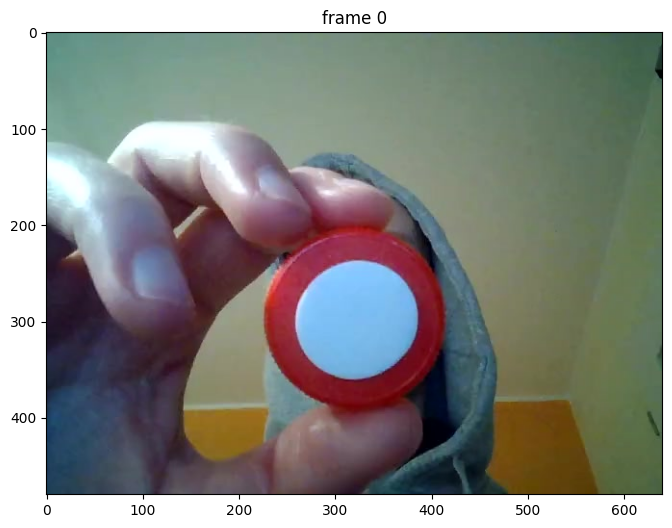

In [7]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/redcap"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [8]:
inference_state = predictor.init_state(video_path=video_dir, offload_video_to_cpu=True)

frame loading (JPEG): 100%|██████████| 207/207 [00:04<00:00, 46.99it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [9]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the white dot.

Here we make a **positive click** at (x, y) = (320, 300) with label `1`, and **negative click** at (x, y) = (240, 300) with label `0` by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

/home/merlin/Github/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/merlin/Github/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


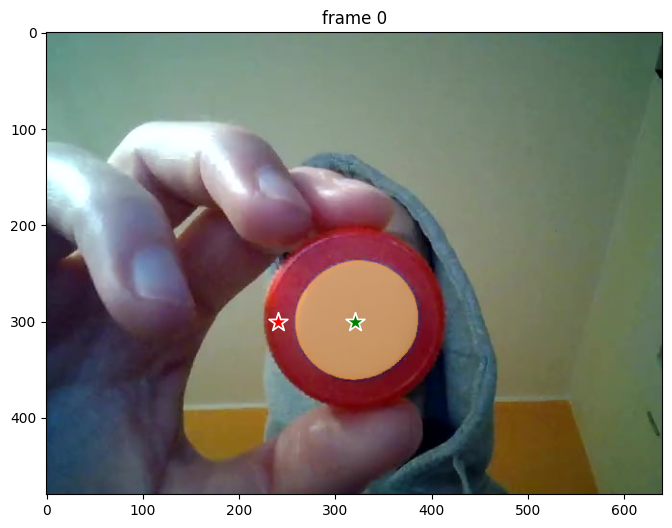

In [15]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (320, 300) and a positive click at (x, y) = (240, 300) to filter the outer red ring.
points = np.array([[320, 300], [240, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video:   0%|          | 0/207 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 207/207 [03:59<00:00,  1.16s/it]


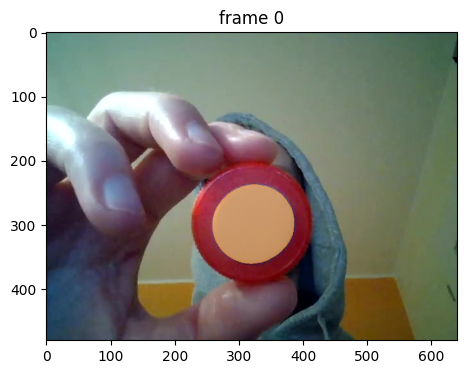

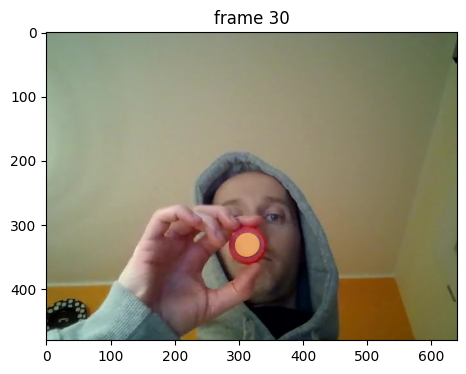

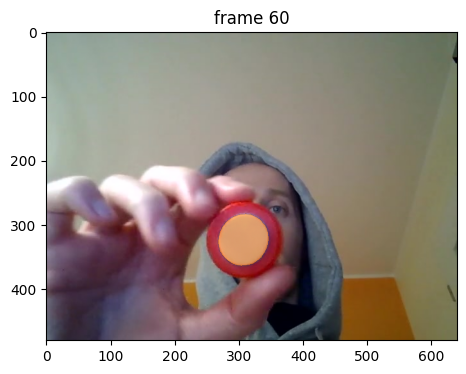

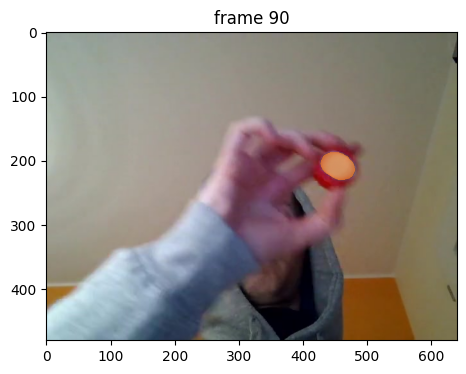

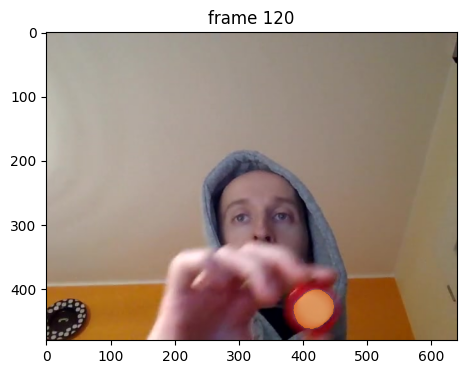

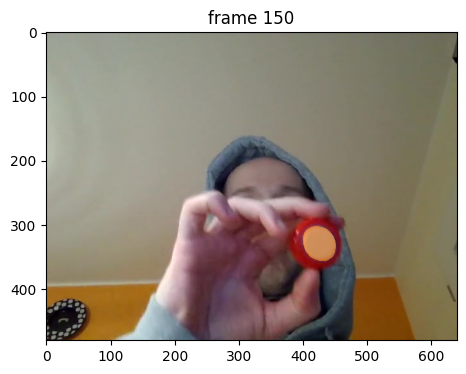

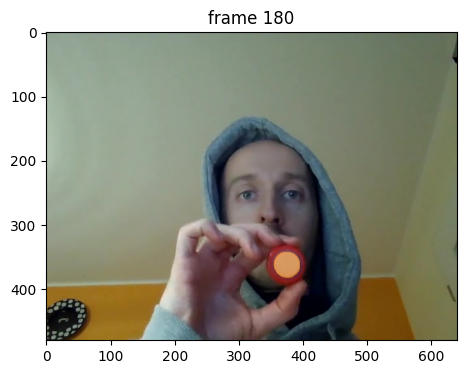

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 40
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

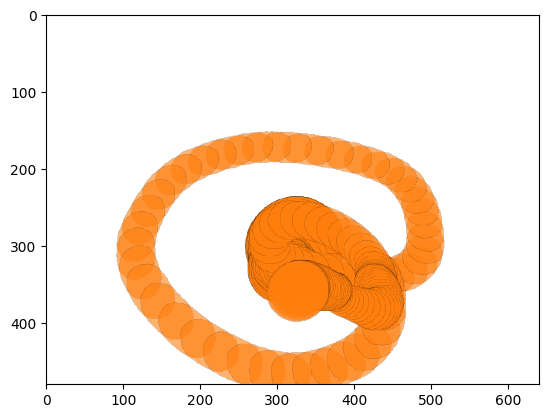

In [208]:
# Show full motion trace of the found masks
for out_frame_idx in range(0, len(frame_names)):
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [207]:
import cv2

# Apply the mask to each frame and save the masked frames
def apply_mask_to_frame(frame, mask, color=(255, 0, 0), mode="mask"):
    mask = mask.squeeze()
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
    color_mask = np.zeros_like(frame)
    color_mask[mask == 1] = color
    match mode.lower():
        case "mask":
            frame_with_mask = cv2.bitwise_and(frame, frame, mask=mask)
        case "segment":
            frame_with_mask = cv2.bitwise_not(frame, frame, mask=mask)
    return frame_with_mask

# Set up the video writer
out_masked_video_path = './videos/redcap_masked.mp4'
out_segmtd_video_path = './videos/redcap_segmtd.mp4'
frame_rate = 30
first_frame = cv2.imread(os.path.join(video_dir, frame_names[0]))
height, width, _ = first_frame.shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_masked = cv2.VideoWriter(out_masked_video_path, fourcc, frame_rate, (width, height))
out_segmtd = cv2.VideoWriter(out_segmtd_video_path, fourcc, frame_rate, (width, height))

# Apply the masks to each frame and save the masked frames
for out_frame_idx in range(0, len(frame_names)):
    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
    frame = cv2.imread(frame_path)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        out_mask = np.array(out_mask).astype(np.uint8)
        frame_masked = apply_mask_to_frame(frame, out_mask, mode='mask')
        frame_segmtd = apply_mask_to_frame(frame, out_mask, mode='segment')
    out_masked.write(frame_masked)
    out_segmtd.write(frame_segmtd)

# Release the video writer to save the video
out_masked.release()
out_segmtd.release()